## Theory 

### LSTM Autoencoder을 통한 Anomaly Detection

{Autoencoder : 자기학습 모델}

- Autoencoder의 경우 보통 이미지의 생성이나 복원에 많이 사용되며 
- 구조를 이어받아 대표적인 딥러닝 생성 모델인 GAN(Generative Adversarial Network)으로 까지 이어짐

- **LSTM Autoencoder 학습 시에는 정상(normal) 신호의 데이터로만 모델을 학습 시킨다**

- encoder와 decoder는 학습이 진행될 수록 정상 신호를 정산 신호 답게 표현 하는 방법을 학습하고
- 최종적으로 재 구성한 결과도 정산 신호와 유사한 분포를 가지는 데이터!!가 된다.

<img src="https://jaehyeongan.github.io/image/lstm-autoencoder-architecture2.png">

- 만약에 비 정상 신호를 입력에 넣게 된다면 정상 분포와 다른 특성의 분포를 나타낼것이기에 높은 reconstruction error가 생길것이다

# Curve shifting을 적용한 lstm autoencoder 

<img src="https://jaehyeongan.github.io/image/lstm-autoencoder-through-curveshifting.png">

- Curve Shifting을 통해 데이터의 시점을 변환
- normal 데이터만들 통해 LSTM Autoencoder 모델을 학습시키고,
- 재구성 손실을 계산 후, Precision Recall Curve를 통해 noraml/adnormal을 구분하기 위한 
- Threshold를 지정하고
- Threshold 기준으로 마지막으로 테스트 셋의 재구성 손실을 분류 t+n 지점을 예측..!

# Curve Shifting 
- Anomal data가 들어오기 전 고장 혹 결함 발생하기 전 미리 예측해야하는 Task 존재
- 단순한 현재 시점의 error 계산은 비정산 신호 탐지하는것에서 고장 발생후의 예측임으로 
- 데이터의 시점 변환이 꼭 필요하다

<img src="https://jaehyeongan.github.io/image/curve-shifting.png" align ="left">

- 사전 예측 개념을 적용하기 위한 shifting method
- pre error prediction

# Anomaly Detection in Keras 

## Threshold by precision-Recall-Curve
- Autoencoder에서 재구성된 결과 vs input를 비교 하여서 Reconstruction error를 계산하는데
- error val 이 낮다면 정상, 높다면 비정상으로 판단하기로 하였다
- 그러면 이 판단 기준은 어떻게 짜야 할까!?


- 보통 classification 같은 경우는 50%를 기준으로 판단을 하지만
- Reconstruction error 같은 경우는 극단적으로 값이 튀기 어렵기에.. 
- 타당한 threshold 값을 정하는 것이 필요하다

# Precision Recall Val

<img src="https://jaehyeongan.github.io/image/precision-recall-curve.png">

- recall과 precision이 tradoff 관계인 점을 이용해서 한쪽에 치우치는 않는 케이스를 찾기 위한 과정으로 
- precision recall curve를 사용해준다

# Sheet Break DATA - binary data

In [60]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from collections import Counter
import tensorflow as tf
# tensorflow 1.x version 2.x version i need
from tensorflow.keras import Model ,models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [61]:
df = pd.read_csv("processminer-rare-event-mts - data.csv")

In [62]:
LABELS = ['Normal', 'Break']

In [63]:
df.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [64]:
Counter(df['y']) # noraml 18274, break 124

Counter({0: 18274, 1: 124})

# Curve Shifting 
- 시간은 2분단위로 
- 우리의 목표는 break 발생하기 4분 전에 조기 예측 

In [65]:
sign = lambda x: (1, -1)[x < 0]
def curve_shift(df, shift_by):
    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)

    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)

    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})

    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [66]:
# shift the response column y by 2 rows to do a 4-min ahead prediction
shifted_df = curve_shift(df, shift_by=-5)
shifted_df.head()


,y,time,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,0.0,5/1/99 0:00,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,0.0,5/1/99 0:02,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,0.0,5/1/99 0:04,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,0.0,5/1/99 0:06,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,0.0,5/1/99 0:08,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [67]:
# drop remove columns
shifted_df = shifted_df.drop(['time','x28','x61'], axis=1)

In [68]:
# x, y
input_x = shifted_df.drop('y', axis=1).values
input_y = shifted_df['y'].values

n_features = input_x.shape[1]

# Transform to Series Data

- LSTM 모델은 (samples, timesteps, feature)에 해당하는 3d 차원의 shape을 가지므로
- 데이터를 시퀀스 형태로 변환한다. timesteps은 5(즉, 10분)만큼 잡았다.

In [69]:
def temporalize(X, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(X) - timesteps - 1):
        t = []
        for j in range(1, timesteps + 1):
            # Gather the past records upto the lookback period
            t.append(X[[(i + j + 1)], :])
        output_X.append(t)
        output_y.append(y[i + timesteps + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)
timesteps = 5

In [70]:
# Temporalize
x, y = temporalize(input_x, input_y, timesteps)
print(x.shape) # (18268, 5, 59)

(18268, 5, 59)


## Data Split

In [71]:
# Split into train, valid, and test 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

print(len(x_train))  # 11691
print(len(x_valid))  # 2923
print(len(x_test))   # 3654

11691
2923
3654


In [72]:
# Autoencoder 학습시에는 normal 만 학습할것이기에 데이터를 normal break 분리한다
# For training the autoencoder, split 0 / 1
x_train_y0 = x_train[y_train == 0]
x_train_y1 = x_train[y_train == 1]

x_valid_y0 = x_valid[y_valid == 0]
x_valid_y1 = x_valid[y_valid == 1]

## Standardize

In [73]:
# 각기 다른 데이터의 특성 표준화 하기 위해 z-score 정규화 시킴
# standartScaler() 적용을 위해는 2d 형태야 함으로 flatten 후 스케일 적용
# 다시 3d 형태로 변환 

In [74]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])

    return X


scaler = StandardScaler().fit(flatten(x_train_y0))

x_train_y0_scaled = scale(x_train_y0, scaler)
x_valid_scaled = scale(x_valid, scaler)
x_valid_y0_scaled = scale(x_valid_y0, scaler)
x_test_scaled = scale(x_test, scaler)

## Training LSTM Autoencoder
- 대칭 구조의 staked Autoencoder 형태로 lstm autoencoder 구성
- 정상 데이터로 만 구성된 데이터를 학습 

In [75]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [76]:
epochs = 200
batch = 128
lr = 0.001

models =Sequential()
# Encoder
models.add(layers.LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
models.add(layers.LSTM(16, activation='relu', return_sequences=False))
models.add(layers.RepeatVector(timesteps))
# Decoder
models.add(layers.LSTM(16, activation='relu', return_sequences=True))
models.add(layers.LSTM(32, activation='relu', return_sequences=True))
models.add(layers.TimeDistributed(layers.Dense(n_features)))
models.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 5, 32)             11776     
_________________________________________________________________
lstm_17 (LSTM)               (None, 16)                3136      
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 5, 16)             0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 5, 16)             2112      
_________________________________________________________________
lstm_19 (LSTM)               (None, 5, 32)             6272      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 5, 59)             1947      
Total params: 25,243
Trainable params: 25,243
Non-trainable params: 0
__________________________________________________

In [77]:
models.compile(loss='mse', optimizer=optimizers.Adam(lr))

In [78]:
history = models.fit(x_train_y0_scaled, x_train_y0_scaled,
                     epochs=epochs, batch_size=batch,
                     validation_data=(x_valid_y0_scaled, x_valid_y0_scaled))

Train on 11307 samples, validate on 2834 samples
Epoch 1/200
11307/11307 [==============================] - 3s 268us/sample - loss: 0.8846 - val_loss: 0.7049
Epoch 2/200
11307/11307 [==============================] - 1s 66us/sample - loss: 0.5788 - val_loss: 0.4534
Epoch 3/200
11307/11307 [==============================] - 1s 68us/sample - loss: 0.4188 - val_loss: 0.3627
Epoch 4/200
11307/11307 [==============================] - 1s 69us/sample - loss: 0.3526 - val_loss: 0.3130
Epoch 5/200
11307/11307 [==============================] - 1s 69us/sample - loss: 0.3124 - val_loss: 0.2835
Epoch 6/200
11307/11307 [==============================] - 1s 69us/sample - loss: 0.2874 - val_loss: 0.2645
Epoch 7/200
11307/11307 [==============================] - 1s 70us/sample - loss: 0.2674 - val_loss: 0.2476
Epoch 8/200
11307/11307 [==============================] - 1s 69us/sample - loss: 0.2512 - val_loss: 0.2363
Epoch 9/200
11307/11307 [==============================] - 1s 67us/sample - loss: 0.24

Epoch 76/200
11307/11307 [==============================] - 1s 68us/sample - loss: 0.1416 - val_loss: 0.1409
Epoch 77/200
11307/11307 [==============================] - 1s 70us/sample - loss: 0.1399 - val_loss: 0.1405
Epoch 78/200
11307/11307 [==============================] - 1s 76us/sample - loss: 0.1403 - val_loss: 0.1401
Epoch 79/200
11307/11307 [==============================] - 1s 67us/sample - loss: 0.1385 - val_loss: 0.1390
Epoch 80/200
11307/11307 [==============================] - 1s 67us/sample - loss: 0.1397 - val_loss: 0.1399
Epoch 81/200
11307/11307 [==============================] - 1s 66us/sample - loss: 0.1417 - val_loss: 0.1401
Epoch 82/200
11307/11307 [==============================] - 1s 65us/sample - loss: 0.1389 - val_loss: 0.1389
Epoch 83/200
11307/11307 [==============================] - 1s 64us/sample - loss: 0.1381 - val_loss: 0.1374
Epoch 84/200
11307/11307 [==============================] - 1s 65us/sample - loss: 0.1386 - val_loss: 0.1396
Epoch 85/200
11307/

11307/11307 [==============================] - 1s 80us/sample - loss: 0.1265 - val_loss: 0.1281
Epoch 151/200
11307/11307 [==============================] - 1s 75us/sample - loss: 0.1262 - val_loss: 0.1272
Epoch 152/200
11307/11307 [==============================] - 1s 74us/sample - loss: 0.1268 - val_loss: 0.1277
Epoch 153/200
11307/11307 [==============================] - 1s 74us/sample - loss: 0.1270 - val_loss: 0.1286
Epoch 154/200
11307/11307 [==============================] - 1s 72us/sample - loss: 0.1266 - val_loss: 0.1282
Epoch 155/200
11307/11307 [==============================] - 1s 69us/sample - loss: 0.1265 - val_loss: 0.1277
Epoch 156/200
11307/11307 [==============================] - 1s 70us/sample - loss: 0.1261 - val_loss: 0.1271
Epoch 157/200
11307/11307 [==============================] - 1s 69us/sample - loss: 0.1271 - val_loss: 0.1288
Epoch 158/200
11307/11307 [==============================] - 1s 73us/sample - loss: 0.1282 - val_loss: 0.1288
Epoch 159/200
11307/1130

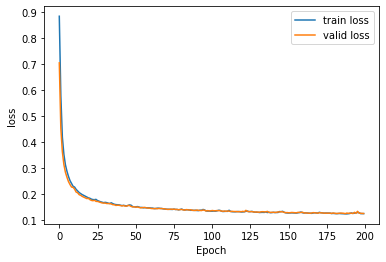

In [79]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

## Threshold by Precision Recall Curve
- 주의점 : 디코딩 된 재구성 결과가 아닌 Reconstruction error 와 실제 라벨 값을 비교 

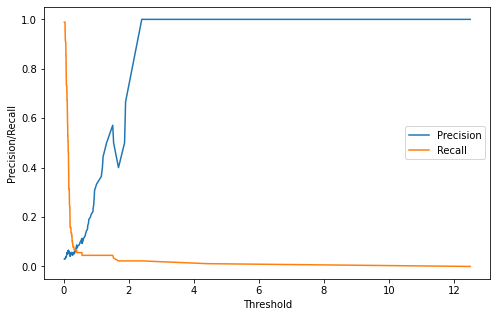

In [80]:
valid_x_predictions = models.predict(x_valid_scaled)
mse = np.mean(np.power(flatten(x_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error':mse, 
                         'True_class':list(y_valid)})
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()
# -

In [81]:
# best position of threshold
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

precision:  0.06741573033707865 , recall:  0.06741573033707865


In [82]:
# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

threshold:  0.36430022134547946


# Predict Test

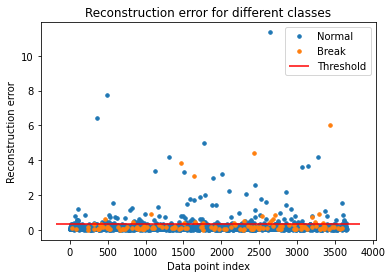

In [83]:
test_x_predictions = models.predict(x_test_scaled)
mse = np.mean(np.power(flatten(x_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': y_test.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Evaluation

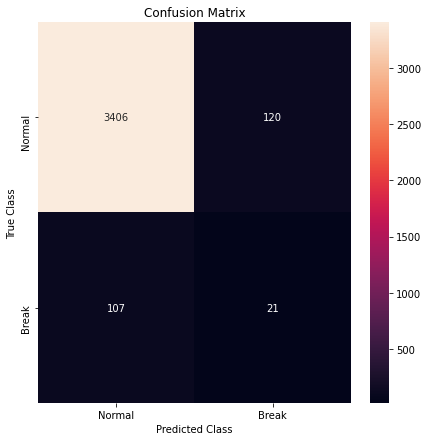

In [84]:
# classification by threshold
pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error'].values]

conf_matrix = metrics.confusion_matrix(error_df['True_class'], pred_y)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

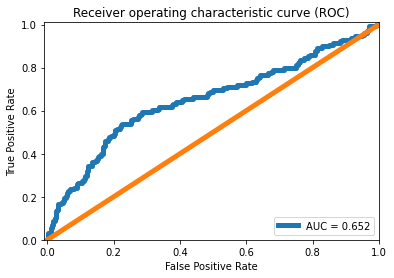

In [85]:
# ROC Curve and AUC

false_pos_rate, true_pos_rate, thresholds = metrics.roc_curve(error_df['True_class'], error_df['Reconstruction_error'])
roc_auc = metrics.auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate')
plt.show()

In [86]:
pred_y[-12:] 

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

# Anomaly Detection in Keras 

- Anomaly Detection is unsupervised training tech 
- Analyzes the degree to which incoming data is different than data that you used to train the neural network
- Cybersecurity used anomaly detection to ensure network security 

---
## In Game 
- Already so many company use Anomaly Detection finding aka. GameBot

## **google cloud tech presentation** - in May 10, 2019
- Netmable

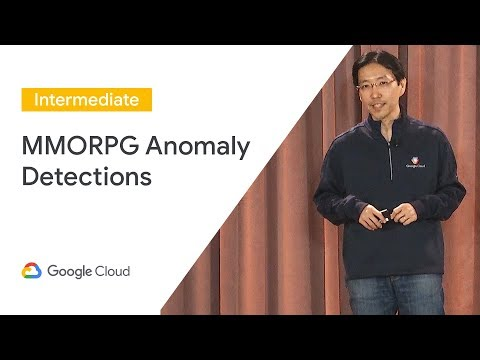

In [87]:
from IPython.display import YouTubeVideo
YouTubeVideo('xrZ9BRK5WAg', width=600, height=480)

<img src="https://blog.kakaocdn.net/dn/2EwaL/btq60IMBfzV/2TWCr5YyVhHWLjRrj2P3T1/img.png" align ="left">

- 기존 규칙 기반의 봇 탐지 보다 확실히 좋은.. 성능

##### 

# 그럼 예제 문제 시작하겠습니다.

#### KDD99 DATA SET
- Old dataset 20 years old 
- Still widely used to demonstarate intrusion Detection system 
- Used for international knowledge Discovery and Data Mining Tools Competition

### Tasks 

- build a network intrusion detector **침입 감지**
    - predictive model capable of distinguishing between **"bad"**, **"good"** connection 

> TMI

- This database contains a standard set of data to be audited,
- including a wide variety of intrusions simulated in a military network environment.

##### Note 
- kdd99 does not include column names, caus to old 

In [88]:
import pandas as pd
from tensorflow.keras.utils import get_file

pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 5)

try:
    path = get_file('kddcup.data_10_percent.gz', origin=\
    'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise
    
print(path) 

df = pd.read_csv(path, header=None)

print("Read {} rows.".format(len(df)))

df.dropna(inplace=True,axis=1) 

df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

# display 5 rows
pd.set_option('display.max_columns', 5)
pd.set_option('display.max_rows', 5)
df

/home/flycode77/.keras/datasets/kddcup.data_10_percent.gz
Read 494021 rows.


,duration,protocol_type,...,dst_host_srv_rerror_rate,outcome
0,0,tcp,...,0.0,normal.
1,0,tcp,...,0.0,normal.
...,...,...,...,...,...
494019,0,tcp,...,0.0,normal.
494020,0,tcp,...,0.0,normal.


In [89]:
# "outcome" specifies either "normal," indicating no attack, or the type of attack performed. 

In [90]:
df.groupby('outcome')["outcome"].count()

outcome
back.               2203
buffer_overflow.      30
                    ... 
warezclient.        1020
warezmaster.          20
Name: outcome, Length: 23, dtype: int64

### Preprocessing

- Before MLP learn need some processing 
    - 1. The first function converts numeric columns into Z-Scores. # 정규화
    - 2. The second function replaces categorical values with dummy variables.

In [91]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] 
# for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


In [92]:
# Now encode the feature vector

pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 5)

encode_numeric_zscore(df, 'duration')
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_text_dummy(df, 'land')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_text_dummy(df, 'logged_in')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')

# display 5 rows

df.dropna(inplace=True,axis=1)
df[0:5]

,duration,src_bytes,dst_bytes,...,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,...,1,1,0
1,-0.067792,-0.002820,-0.011578,...,1,1,0
2,-0.067792,-0.002824,0.014179,...,1,1,0
3,-0.067792,-0.002840,0.014179,...,1,1,0
4,-0.067792,-0.002842,0.035214,...,1,1,0


# TO DO ANOMALY DETECTION 
- Perform anomaly detection, 
- Data need to divide by two grouop ("Normal", "various Attack ")

In [93]:
normal_mask = df['outcome']=='normal.'
attack_mask = df['outcome']!='normal.'

df.drop('outcome',axis=1,inplace=True)

df_normal = df[normal_mask]
df_attack = df[attack_mask]

print(f"Normal count: {len(df_normal)}")
print(f"Attack count: {len(df_attack)}")

Normal count: 97278
Attack count: 396743


In [94]:
# Convert DataFrame into Numpy arrays, keras need numpy
x_normal = df_normal.values
x_attack = df_attack.values

## Training the Autoencoder 

- important to note that we are not using the outcome column as a label to predict
- This anomaly detection is unsupervised
- **no target (y)**
- train an autoencoder on the normal data 
- see how well it can detect that the data not flagged as "normal" represents an anomaly

In [95]:
from sklearn.model_selection import train_test_split

x_normal_train, x_normal_test = train_test_split(
    x_normal, test_size=0.3, random_state=77)

In [96]:
print(f"Normal train count: {len(x_normal_train)}")
print(f"Normal test count: {len(x_normal_test)}")

Normal train count: 68094
Normal test count: 29184


# How to learn?

- The autoencoder will learn to compress the data to a vector of just three numbers
- autoencoder should be able to also decompress with reasonable accuracy

In [97]:
from sklearn import metrics
import numpy as np
import pandas as pd
from IPython.display import display, HTML 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(25, input_dim=x_normal.shape[1], activation='relu'))
model.add(Dense(3, activation='relu')) # size to compress to

model.add(Dense(25, activation='relu'))
model.add(Dense(x_normal.shape[1])) # Multiple output neurons

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_normal_train,x_normal_train,verbose=1,epochs=100)

Epoch 1/100
68094/68094 [==============================] - 2s 35us/sample - loss: 0.4558
Epoch 2/100
68094/68094 [==============================] - 1s 20us/sample - loss: 0.3404
Epoch 3/100
68094/68094 [==============================] - 1s 20us/sample - loss: 0.2653
Epoch 4/100
68094/68094 [==============================] - 1s 19us/sample - loss: 0.2524
Epoch 5/100
68094/68094 [==============================] - 1s 20us/sample - loss: 0.1907
Epoch 6/100
68094/68094 [==============================] - 1s 20us/sample - loss: 0.1941
Epoch 7/100
68094/68094 [==============================] - 1s 19us/sample - loss: 0.1948
Epoch 8/100
68094/68094 [==============================] - 1s 19us/sample - loss: 0.1834
Epoch 9/100
68094/68094 [==============================] - 1s 19us/sample - loss: 0.1993
Epoch 10/100
68094/68094 [==============================] - 1s 19us/sample - loss: 0.1783
Epoch 11/100
68094/68094 [==============================] - 1s 19us/sample - loss: 0.1800
Epoch 12/100
68094/

68094/68094 [==============================] - 1s 19us/sample - loss: 0.1039
Epoch 93/100
68094/68094 [==============================] - 1s 19us/sample - loss: 0.1045
Epoch 94/100
68094/68094 [==============================] - 1s 19us/sample - loss: 0.1017
Epoch 95/100
68094/68094 [==============================] - 1s 19us/sample - loss: 0.1029
Epoch 96/100
68094/68094 [==============================] - 1s 19us/sample - loss: 0.1044
Epoch 97/100
68094/68094 [==============================] - 1s 19us/sample - loss: 0.1008
Epoch 98/100
68094/68094 [==============================] - 1s 19us/sample - loss: 0.1008
Epoch 99/100
68094/68094 [==============================] - 1s 19us/sample - loss: 0.1034
Epoch 100/100
68094/68094 [==============================] - 1s 19us/sample - loss: 0.0937


# Detecting an Anomaly 

- encoding data that represents an attack. This higher error indicates an anomaly.

In [98]:
pred = model.predict(x_normal_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,x_normal_test))
pred = model.predict(x_normal)
score2 = np.sqrt(metrics.mean_squared_error(pred,x_normal))
pred = model.predict(x_attack)
score3 = np.sqrt(metrics.mean_squared_error(pred,x_attack))
print(f"Out of Sample Normal Score (RMSE): {score1}")
print(f"Insample Normal Score (RMSE): {score2}")
print(f"Attack Underway Score (RMSE): {score3}")

Out of Sample Normal Score (RMSE): 0.3306574651748449
Insample Normal Score (RMSE): 0.32958383415984016
Attack Underway Score (RMSE): 0.5283584940098758
